In [41]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,BatchNormalization,Dropout
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.resnet_v2 import ResNet50V2

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d msambare/fer2013

 81% 49.0M/60.3M [00:00<00:00, 60.0MB/s]
100% 60.3M/60.3M [00:00<00:00, 63.9MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fer2013.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
img_shape=96
batchs=32

train_ds=keras.utils.image_dataset_from_directory(directory='/content/train',labels='inferred',label_mode='int',batch_size=batchs,
                                         image_size=(img_shape,img_shape))
test_ds=keras.utils.image_dataset_from_directory(directory='/content/test',labels='inferred',label_mode='int',batch_size=batchs,
                                         image_size=(img_shape,img_shape))

label_names=train_ds.class_names
train_labels=train_ds.labels
test_labels=test_ds.labels

def process(img,lab):
  img=tf.cast(img/255,tf.float32)
  return img,lab
train_ds=train_ds.map(process)
test_ds=test_ds.map(process)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [ ]:
Early_Stopping = keras.callbacks.EarlyStopping(monitor = 'val_sparse_categorical_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',factor=0.4,patience=3,verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

In [ ]:
cnn_model=Sequential()
cnn_model.add(Conv2D(32,(3,3),(1,1),padding='same',activation='relu',input_shape=(img_shape,img_shape,3)))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64,(3,3),(1,1),padding='same',activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(32,(3,3),(1,1),padding='same',activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64,(3,3),(1,1),padding='same',activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(128,(3,3),(1,1),padding='same',activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
cnn_model.add(Dropout(0.2))

cnn_model.add(Flatten())

cnn_model.add(Dense(512,activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(256,activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(128,activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(64,activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(32,activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.2))

cnn_model.add(Dense(7,activation='softmax'))

In [ ]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_13 (Ba  (None, 96, 96, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 batch_normalization_14 (Ba  (None, 96, 96, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                      

In [ ]:
cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
  )
cnn_history = cnn_model.fit(train_ds,epochs=50,validation_data=test_ds,callbacks=callbacks,batch_size=batchs)

In [ ]:
CNN_Score = cnn_model.evaluate(test_ds)

print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

225/225 [==============================] - 4s 16ms/step - loss: 1.1101 - sparse_categorical_accuracy: 0.6096
    Test Loss: 1.11005
Test Accuracy: 60.96%


In [ ]:
cnn_model.save("my_cnn_61.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["sparse_categorical_accuracy"]
    val_accuracy = history.history["val_sparse_categorical_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()


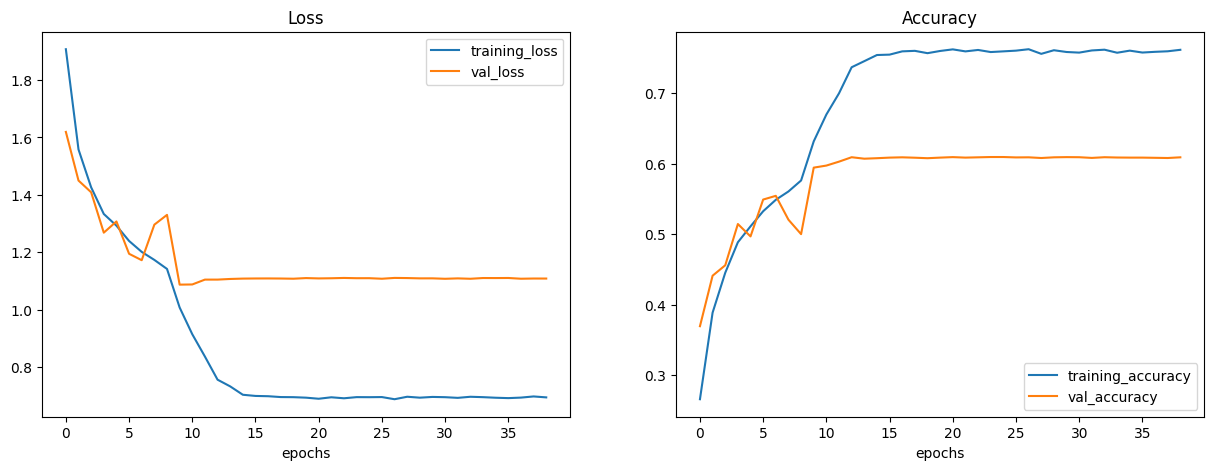

In [ ]:
plot_curves(cnn_history)

In [ ]:
CNN_Predictions = cnn_model.predict(test_ds)

# Choosing highest probalbilty class in every prediction
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

In [37]:
data=[]
cats=[]
label=[]
i=0
for root,subdirs,files in os.walk('/content/test'):
    if(root=='/content/test'):
        cats=subdirs
    else:
        a=[]
        for file in files:
            # print(root+file)
            data.append(cv2.resize(cv2.imread(root+'/'+file),(96,96)))
            label.append(cats[i])
        i+=1
np.unique(label,return_counts=True)
data=np.array(data)
X_test=data
y_test=np.array(label)
X_test=X_test/255
cats=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

225/225 [==============================] - 3s 13ms/step
accuracy :  0.6058790749512399


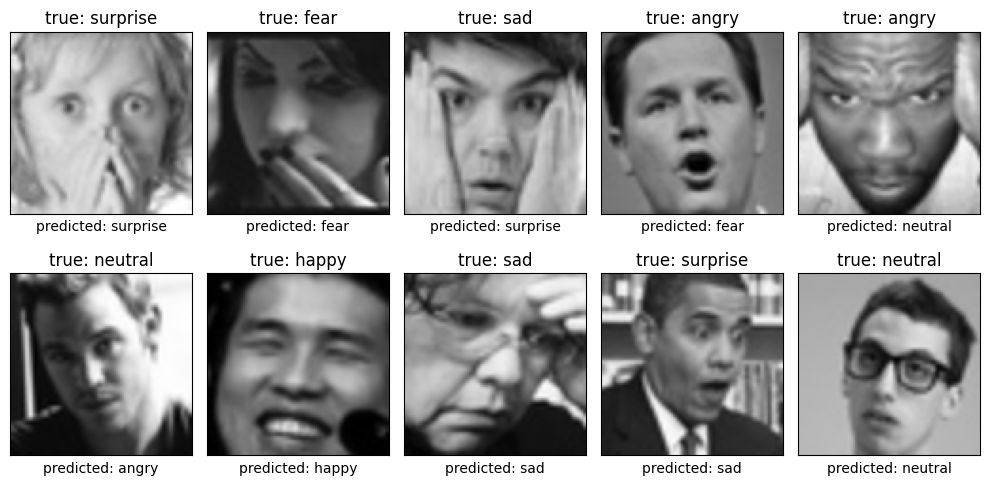

In [ ]:
p=cnn_model.predict(X_test)
y_pred=[]
for p1 in p:
    y_pred.append(cats[p1.argmax()])
y_pred
import random
print("accuracy : ",accuracy_score(y_pred,y_test))
plt.figure(figsize=(10, 5))
for j in range(0,10):
    plt.subplot(2, 5, j + 1)
    plt.xticks(())
    plt.yticks(())
    i=random.randint(0,len(X_test)-1)
    plt.title(f"true: {y_test[i]}")
    # print()
    plt.imshow(X_test[i],cmap='gray')
    plt.xlabel(f"predicted: {y_pred[i]}")
plt.tight_layout()
plt.show()

In [ ]:
# specifing new image shape for resnet
img_shape = 192
batch_size = 64
train_data_path = '../content/train/'
test_data_path = '../content/test/'

In [15]:
img_shape=96
batchs=32

train_ds=keras.utils.image_dataset_from_directory(directory='/content/train',labels='inferred',label_mode='int',batch_size=batchs,
                                         image_size=(img_shape,img_shape))
test_ds=keras.utils.image_dataset_from_directory(directory='/content/test',labels='inferred',label_mode='int',batch_size=batchs,
                                         image_size=(img_shape,img_shape))

label_names=train_ds.class_names

def process(img,lab):
  img=tf.cast(img/255,tf.float32)
  return img,lab
train_ds=train_ds.map(process)
test_ds=test_ds.map(process)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [16]:
conv_base=ResNet50V2(include_top=False,weights="imagenet",input_shape=(img_shape,img_shape,3))

In [17]:
conv_base.trainable = True

for layer in conv_base.layers[:-50]:
    layer.trainable = False

In [18]:
conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 102, 102, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 48, 48, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 50, 50, 64)           0         ['conv1_conv[0][0]']          
                                                                                         

In [19]:
model = Sequential()

model.add(conv_base)
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(7,activation='softmax'))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 dropout_4 (Dropout)         (None, 3, 3, 2048)        0         
                                                                 
 batch_normalization_4 (Bat  (None, 3, 3, 2048)        8192      
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               4718848   
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)                                     

In [31]:
# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True, verbose=1)
# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2,verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

In [32]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )
ResNetV2_history = model.fit(train_ds,epochs=50,validation_data=test_ds,callbacks=callbacks)

Epoch 1/50
898/898 [==============================] - 57s 52ms/step - loss: 0.2597 - accuracy: 0.9176 - val_loss: 1.7025 - val_accuracy: 0.5847 - lr: 0.0010
Epoch 2/50
898/898 [==============================] - 46s 52ms/step - loss: 0.2901 - accuracy: 0.9063 - val_loss: 1.6440 - val_accuracy: 0.5970 - lr: 0.0010
Epoch 3/50
898/898 [==============================] - 51s 57ms/step - loss: 0.2621 - accuracy: 0.9144 - val_loss: 1.9230 - val_accuracy: 0.5846 - lr: 0.0010
Epoch 4/50
898/898 [==============================] - ETA: 0s - loss: 0.2574 - accuracy: 0.9169
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
898/898 [==============================] - 47s 52ms/step - loss: 0.2574 - accuracy: 0.9169 - val_loss: 1.7355 - val_accuracy: 0.5872 - lr: 0.0010
Epoch 5/50
898/898 [==============================] - 45s 51ms/step - loss: 0.1341 - accuracy: 0.9580 - val_loss: 1.9237 - val_accuracy: 0.6071 - lr: 5.0000e-04
Epoch 6/50
898/898 [==============================

In [33]:
ResNet50V2_Score = model.evaluate(test_ds)

print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

225/225 [==============================] - 6s 24ms/step - loss: 2.6289 - accuracy: 0.6227
    Test Loss: 2.62886
Test Accuracy: 62.27%


In [34]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()


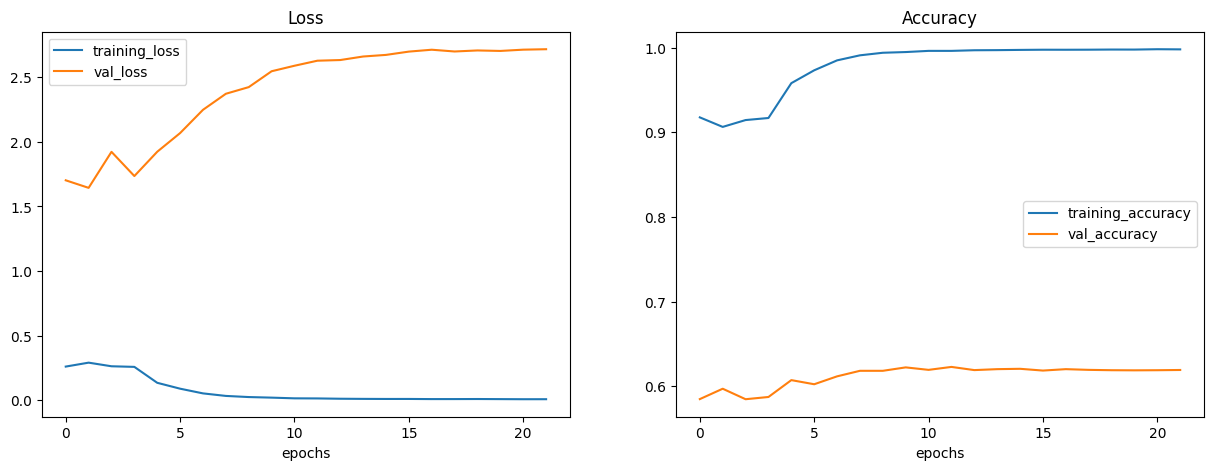

In [35]:
plot_curves(ResNetV2_history)

225/225 [==============================] - 6s 25ms/step


Text(0.5, 1.0, 'ResNet50V2 Confusion Matrix')

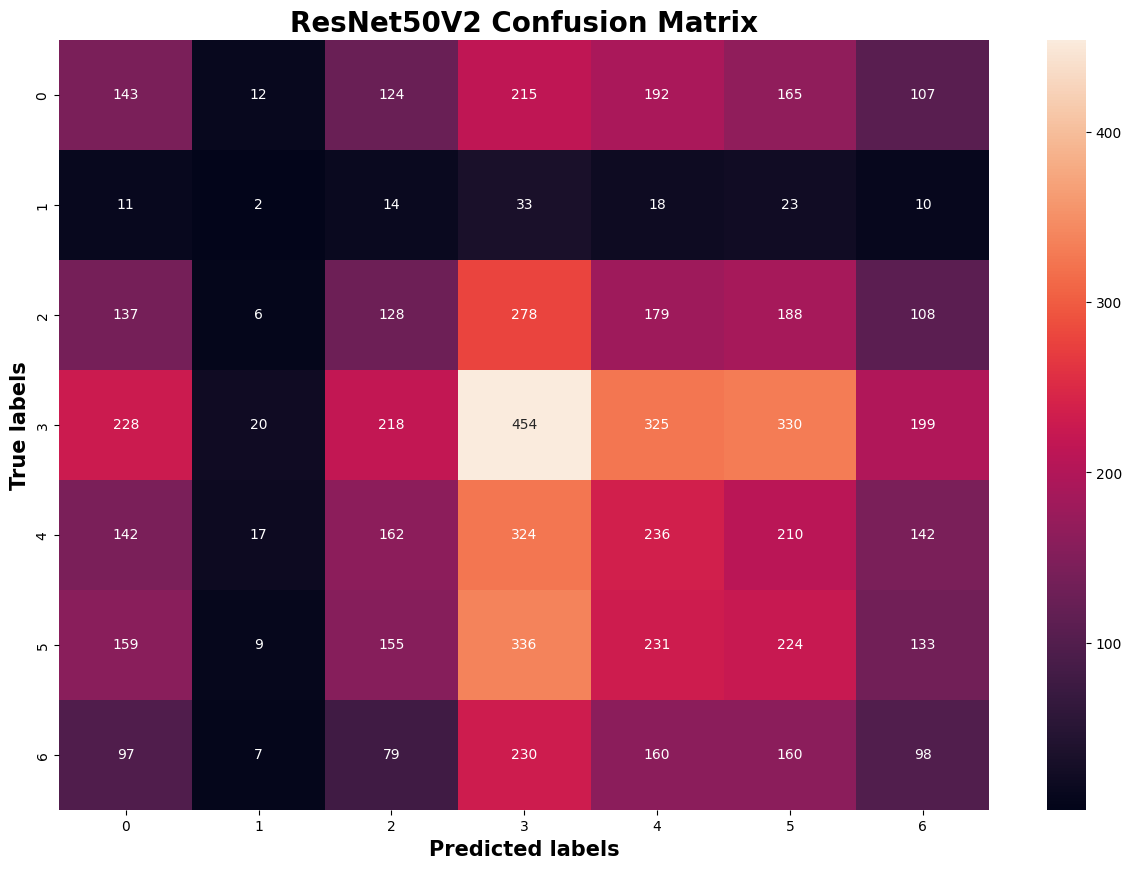

In [43]:
import seaborn as sns
ResNet50V2_Predictions = model.predict(test_ds)

# Choosing highest probalbilty class in every prediction
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)
fig , ax= plt.subplots(figsize=(15,10))
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
cm=confusion_matrix(true_labels, ResNet50V2_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')

225/225 [==============================] - 7s 23ms/step
accuracy :  0.6217609361939259


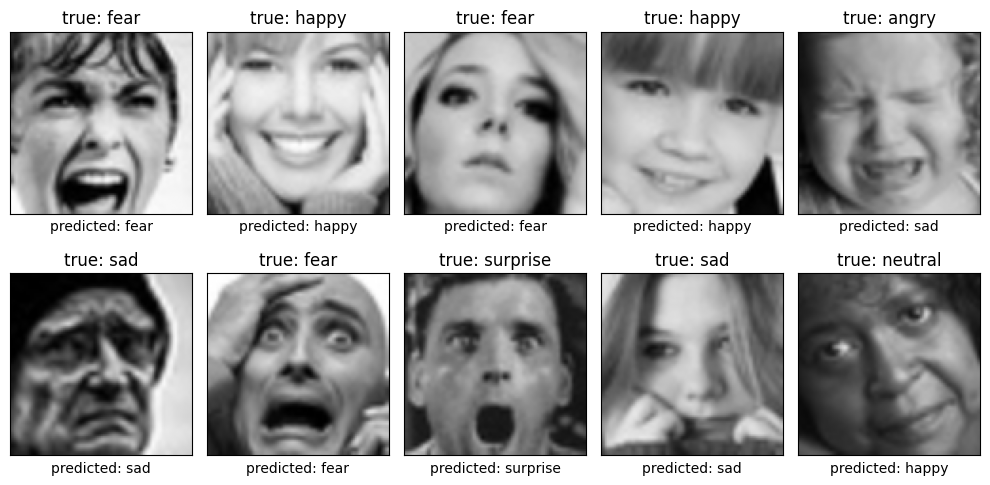

In [38]:
# checking predicted labels and true labels for random test samples
p=model.predict(X_test)
y_pred=[]
for p1 in p:
    y_pred.append(cats[p1.argmax()])
y_pred
import random
print("accuracy : ",accuracy_score(y_test,y_pred))
plt.figure(figsize=(10, 5))
for j in range(0,10):
    plt.subplot(2, 5, j + 1)
    plt.xticks(())
    plt.yticks(())
    i=random.randint(0,len(X_test)-1)
    plt.title(f"true: {y_test[i]}")
    # print()
    plt.imshow(X_test[i],cmap='gray')
    plt.xlabel(f"predicted: {y_pred[i]}")
plt.tight_layout()
plt.show()

In [39]:
model.save("ResnetV2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
